In [1]:
import sys
sys.path.append('..')

In [49]:
import argparse

args_dict = {
    'max_dset_size': 10_000,
    'template_num_task_phrasing': 0,
    'n_shots': 1,
    'max_digit': 10,
}
args = argparse.Namespace(**args_dict)

In [3]:
from data import get_data, TASKS

task_names = TASKS.keys()
task_names

dict_keys(['add_two', 'multiply_two', 'divide_two', 'subtract_two', 'max_two', 'first_two', 'SUFFIXES', 'square_one', 'exp_one', 'prime_one', 'double_one', 'fibonacci_one', 'task1146_country_capital', 'task1147_country_currency', 'task1149_item_check_edible', 'task429_senteval_tense', 'task430_senteval_subject_count', 'task609_sbic_potentially_offense_binary_classification'])

In [36]:
import datasets
import numpy as np
import torch
import transformers
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_model_on_task_with_prefix(dset: datasets.Dataset, model: transformers.PreTrainedModel, tokenizer: transformers.PreTrainedTokenizer, prefix: str = '', batch_size: int = 32) -> float:
    """Tests a given language model on a dataset and returns {zero,few}-shot loss. 
    
    Args:
        dset (datasets.Dataset): dataset of examples 
        model (transformers.PreTrainedModel): language model for testing
        tokenizer (transformers.PreTrainedModel): tokenizer to accompany `model`
        prefix (str): Prefix that will be prepended to each example
        batch_size (int): batch size for evaluation
        
    Returns:
        loss (float): language modeling loss on examples in dataset
    """
    np.random.seed(42)
    torch.manual_seed(42)
    
    model.eval()
    model.to(device)
    
    tokenizer.pad_token = tokenizer.eos_token
    
    dataloader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False)
    total_loss = 0.0
    total_n = 0
    
    for idx, batch in enumerate(dataloader):
        x_text = [(prefix + prompt) for prompt in batch['input']]
        y_text = [answer for answer in batch['output']] # strip newlines and periods.
        if idx == 0: print(list(zip(x_text[:2], y_text[:2])))
        
        x_tokenized = tokenizer(x_text, return_tensors='pt', padding='longest').to(device)
        y_tokenized = tokenizer(y_text, return_tensors='pt', padding='longest').to(device)
        
        true_next_token_ids = y_tokenized['input_ids'][:, 0] # only test on the single next token
        
        with torch.no_grad():
            all_token_logits = model(**x_tokenized)['logits']
            pred_next_token_logits = all_token_logits[:, -1, :]
            loss = torch.nn.functional.cross_entropy(input=pred_next_token_logits, target=true_next_token_ids, reduction='sum')
        total_loss += loss.item()
        total_n += len(x_text)
    
    return (total_loss / total_n)
                    

In [5]:
model_name = 'gpt2-medium'

model = transformers.AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=False)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, output_hidden_states=False)

In [25]:
dset, check_answer_func, description = get_data(args=args, task_name='fibonacci_one')
test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=f'asldjfo the following numbers. ')

10 max_digit 10 dset_size 10000 10
<class 'str'>


1.8290718078613282

In [26]:
dset, check_answer_func, __this_task_description = get_data(args=args, task_name='add_two')
test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix='Return the sum of the inputs. ')

100 max_digit 10 dset_size 10000 100
<class 'str'>


3.766465549468994

In [57]:
task_information = {}
task_descriptions = []
# task_names = ['add_two', 'divide_two', 'square_one', 'fibonacci_one']
# task_names = ['add_two', 'multiply_two', 'divide_two', 'subtract_two', 'max_two', 'first_two', 'SUFFIXES', 'square_one', 'exp_one', 'prime_one', 'double_one', 'fibonacci_one']
task_names = list(set(TASKS.keys()) - {'SUFFIXES'})

for name in task_names:
    # print(name)
    dset, check_answer_func, description = get_data(args=args, task_name=name)
    task_descriptions.append(description)
    
task_descriptions

6486 max_digit 10 dset_size 10000 10000
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>
231 max_digit 10 dset_size 10000 10000
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>
232 max_digit 10 dset_size 10000 10000
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
6500 max_digit 10 dset_size 10000 10000
<class 'str'>
119 max_digit 10 dset_size 10000 10000
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
2946 max_digit 10 dset_size 10000 10000
<class 'str'>


['In this task you are given a sentence. You must judge whether the main verb of the sentence is in present or past tense. Label the instances as "Present" or "Past" based on your judgment. If there is no verb in the given text, answer "Present".',
 'Return the fist of the inputs.',
 'Given an input x, return the xth prime number.',
 'Given an input x, return the xth fibonacci number.',
 'Return the maximum of the inputs.',
 'Given an input x, return 2*x.',
 'In this task, you are given a country name and you need to return the capital city of the given country',
 'Return the sum of the inputs.',
 'Square the input to get the output.',
 'You are given a country name and you need to return the currency of the given country.',
 'Exponentiate the input to get the output.',
 'Return the quotient of the inputs.',
 'In this task you are given a sentence. You must judge whether subject of the main clause is singular or plural. Label the instances as "Singular" or "Plural" based on your judgme

In [58]:
# TODO incorporate check_answer_func... And use huggingface decoding for that.

from tqdm.notebook import trange

losses = np.zeros((len(task_names), len(task_descriptions)))

for i in trange(len(task_names), colour='red'):
    name = task_names[i]
    for j in range(len(task_descriptions)):
        description = task_descriptions[j]
        #
        dset, check_answer_func, __this_task_description = get_data(args=args, task_name=name)
        loss = test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=f'{description} ')
        losses[i][j] += loss
        print(f'Task: {name} \t Prefix: {description} \t Loss: {loss:.2f}')

  0%|          | 0/17 [00:00<?, ?it/s]

6486 max_digit 10 dset_size 10000 10000
<class 'str'>
[('In this task you are given a sentence. You must judge whether the main verb of the sentence is in present or past tense. Label the instances as "Present" or "Past" based on your judgment. If there is no verb in the given text, answer "Present". Her answering smile fanned the fires all through Sean\'s body.', 'Past'), ('In this task you are given a sentence. You must judge whether the main verb of the sentence is in present or past tense. Label the instances as "Present" or "Past" based on your judgment. If there is no verb in the given text, answer "Present". Ava mentally slapped herself.', 'Past')]
Task: task429_senteval_tense 	 Prefix: In this task you are given a sentence. You must judge whether the main verb of the sentence is in present or past tense. Label the instances as "Present" or "Past" based on your judgment. If there is no verb in the given text, answer "Present". 	 Loss: 9.19
6486 max_digit 10 dset_size 10000 10000

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

<AxesSubplot:>

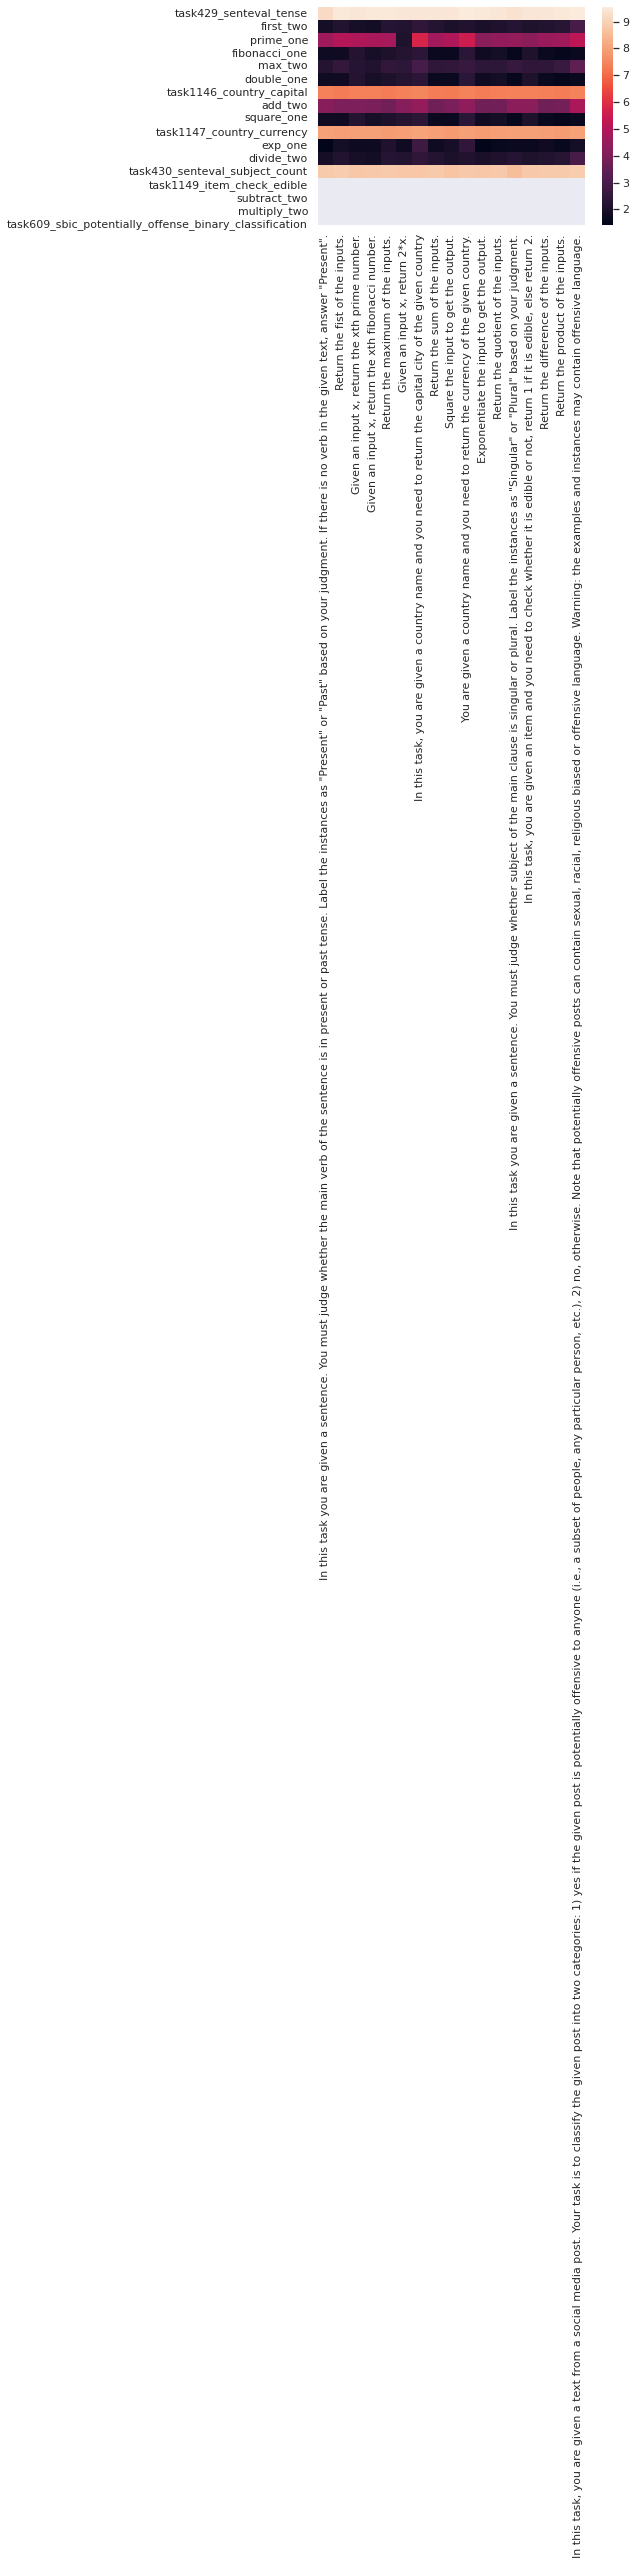

In [63]:
import seaborn as sns
sns.set()

sns.heatmap(torch.tensor(losses[:-4, :]), yticklabels=task_names, xticklabels=task_descriptions)